## Прогнозирование ряда со сложной сезонностью

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок.Создайте регрессионные признаки для учёта сезонностей и трендов.

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import pickle

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (15,8)

In [3]:
with open("region_1128.pkl", "rb") as fid:
    data = pickle.load(fid, encoding='latin1')

p = pd.date_range(start='2014-01-01', periods=data.size, freq='H')
data_region = pd.DataFrame(data, columns = ['val'])
data_region['date'] = p
data_region = data_region.set_index('date')
data_region.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21168 entries, 2014-01-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   val     21168 non-null  float64
dtypes: float64(1)
memory usage: 330.8 KB


In [4]:
data_region.index = pd.DatetimeIndex(data_region.index, freq='H')

<AxesSubplot:xlabel='date'>

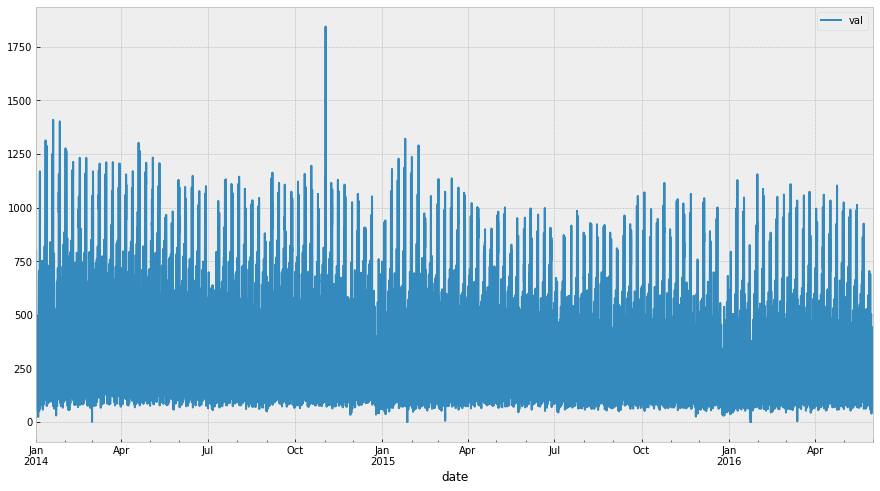

In [5]:
data_region.plot()

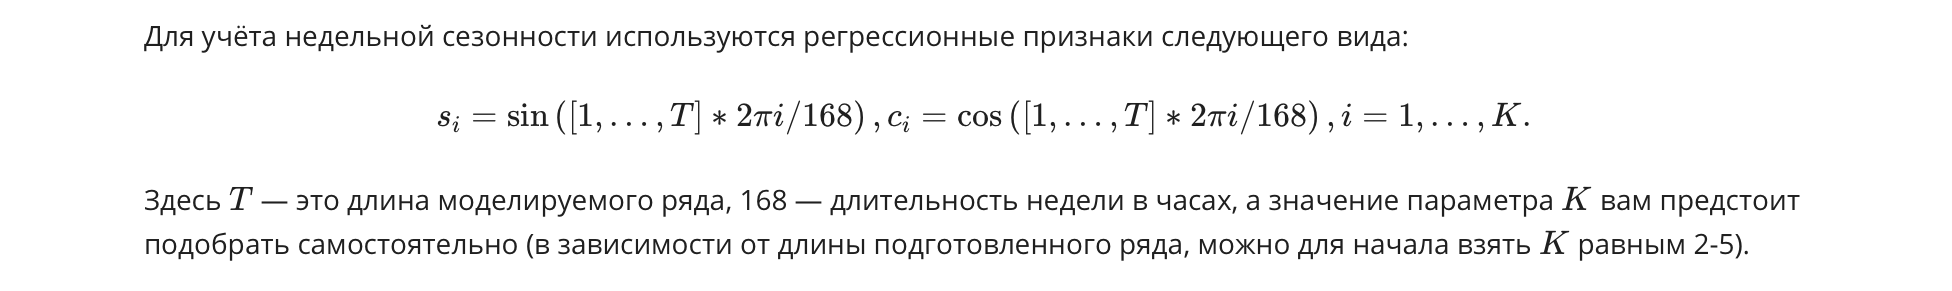

In [6]:
m = 169
n = len(data_region)
for i in range(1, m):
    sin = "sin_" + str(i)
    cos = "cos_" + str(i)
    data_region[sin] = np.sin(2*np.pi*i*np.arange(1, n+1)/168.0)
    data_region[cos] = np.cos(2*np.pi*i*np.arange(1, n+1)/168.0)

Добавим ещё некоторые экзогенные признаки: день недели и час

In [7]:
# data_region['day'] = pd.to_datetime(data_region['tpep_pickup_datetime']).dt.dayofweek
# data_region['hour'] = pd.to_datetime(data_region['tpep_pickup_datetime']).dt.hour

In [8]:
data_region.head()

,val,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,...,sin_164,cos_164,sin_165,cos_165,sin_166,cos_166,sin_167,cos_167,sin_168,cos_168
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,799.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,-0.149042,0.988831,-0.111964,0.993712,-0.074730,0.997204,-0.037391,0.999301,-2.449294e-16,1.0
2014-01-01 01:00:00,635.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,-0.294755,0.955573,-0.222521,0.974928,-0.149042,0.988831,-0.074730,0.997204,-4.898587e-16,1.0
2014-01-01 02:00:00,499.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,-0.433884,0.900969,-0.330279,0.943883,-0.222521,0.974928,-0.111964,0.993712,-7.347881e-16,1.0
2014-01-01 03:00:00,370.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,-0.563320,0.826239,-0.433884,0.900969,-0.294755,0.955573,-0.149042,0.988831,-9.797174e-16,1.0
2014-01-01 04:00:00,319.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,-0.680173,0.733052,-0.532032,0.846724,-0.365341,0.930874,-0.185912,0.982566,-1.224647e-15,1.0


2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.


In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
X = data_region.drop(columns=['val'])
y = data_region['val']

In [11]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [12]:
predictions = model.predict(X)

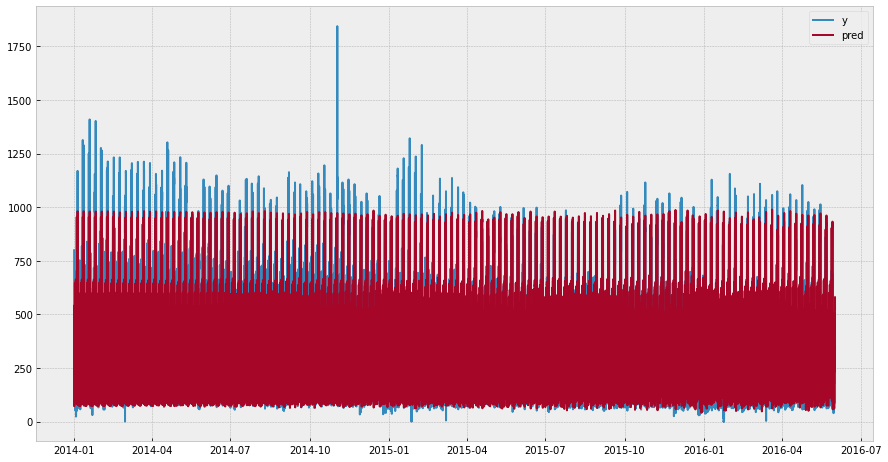

In [13]:
plt.plot(y, label='y')
plt.plot(y.index, predictions, label='pred')
plt.legend()
plt.show()

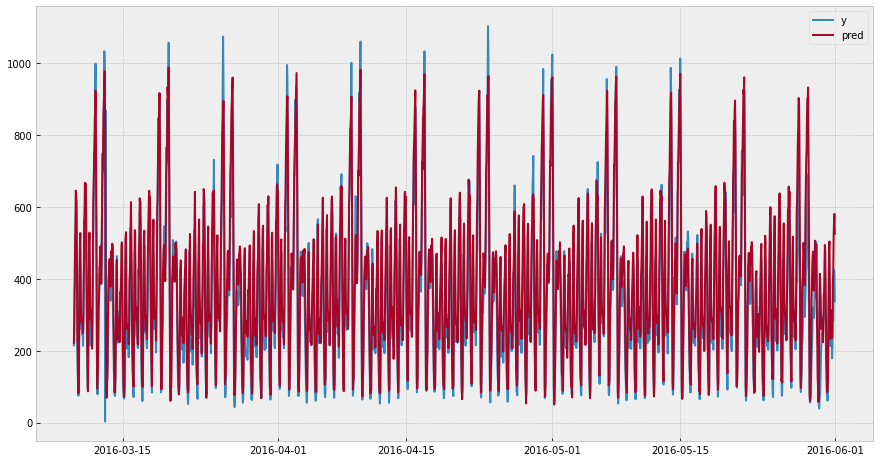

In [14]:
plt.plot(y[-2000:], label='y')
plt.plot(y[-2000:].index, predictions[-2000:], label='pred')
plt.legend()
plt.show()

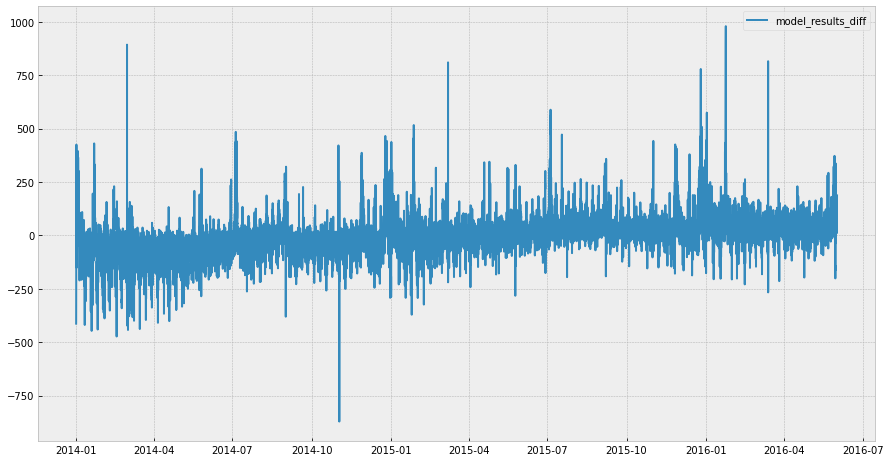

In [15]:
plt.plot(y.index, predictions - y.values , label='model_results_diff')
plt.legend()
plt.show()

In [16]:
data_region['e'] = predictions - y.values

3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [17]:
import statsmodels.api as sm

Критерий Дики-Фуллера: p=0.000000


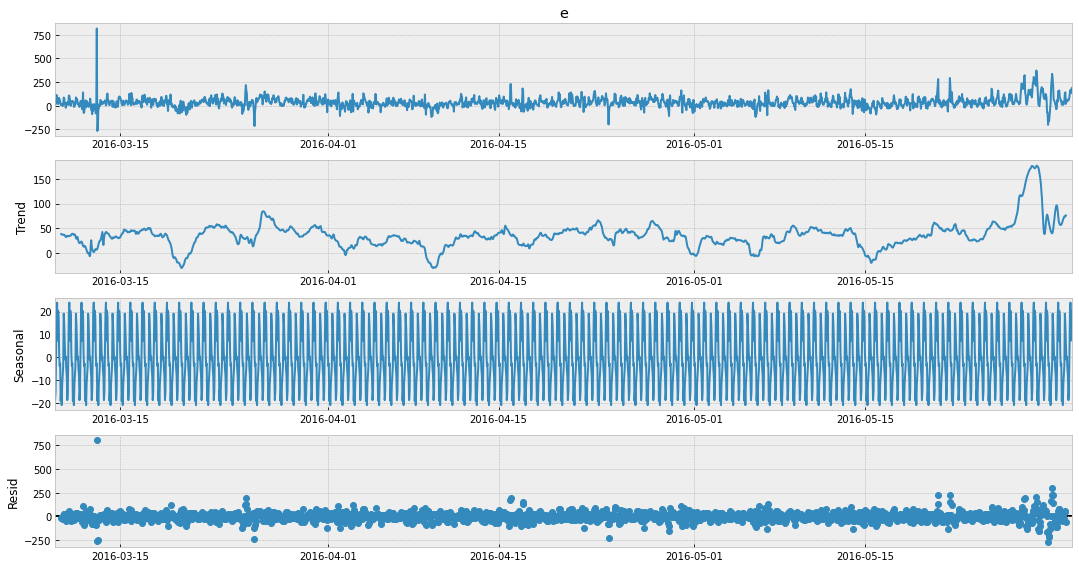

In [18]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_region['e'])[1])
sm.tsa.seasonal_decompose(data_region['e'][-2000:]).plot()
plt.show()

Из декомпозиции ряда и по критерию Дики-Фуллера видно, что ряд остатков является стационарным

4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров 

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

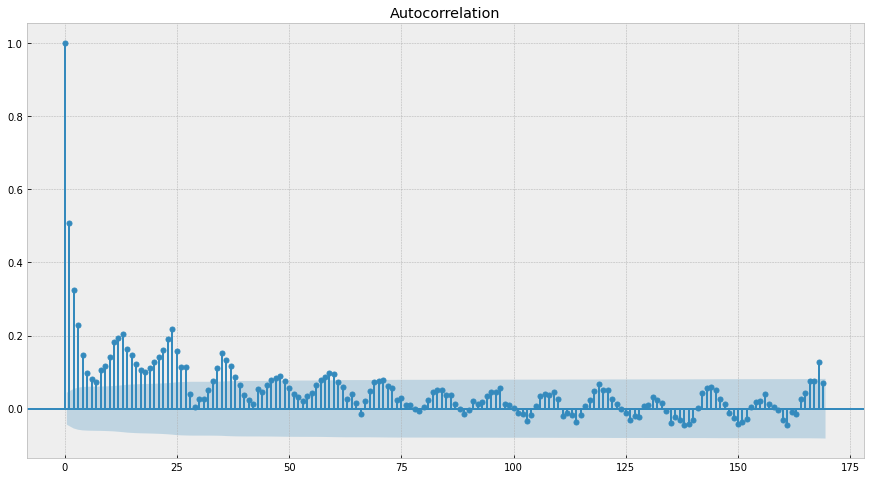

In [21]:
plot_acf(data_region['e'][-2000:].dropna(), lags=169)
plt.show()

In [23]:
q = 6 # последний значимый лаг автокорреляции
Q = 1 # последний значимый сезонный лаг автокорреляции, деленный на период сезонности 

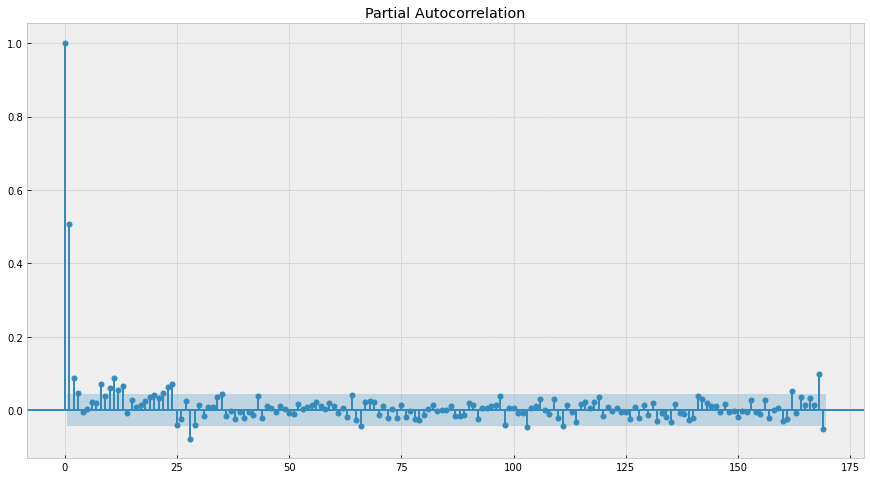

In [24]:
plot_pacf(data_region['e'][-2000:].dropna(), lags=169)
plt.show()

In [25]:
p = 3 # последний значимый лаг частичной автокорреляции
P = 1 # последний значимый сезонный лаг частичной автокорреляции, деленный на период сезонности 

5. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов или поменять порядки дифференцирования.




In [28]:
from itertools import product

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
data_region.head()

,val,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,...,cos_164,sin_165,cos_165,sin_166,cos_166,sin_167,cos_167,sin_168,cos_168,e
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,799.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.988831,-0.111964,0.993712,-0.074730,0.997204,-0.037391,0.999301,-2.449294e-16,1.0,-412.999869
2014-01-01 01:00:00,635.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,0.955573,-0.222521,0.974928,-0.149042,0.988831,-0.074730,0.997204,-4.898587e-16,1.0,-405.293017
2014-01-01 02:00:00,499.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,0.900969,-0.330279,0.943883,-0.222521,0.974928,-0.111964,0.993712,-7.347881e-16,1.0,-336.231196
2014-01-01 03:00:00,370.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,0.826239,-0.433884,0.900969,-0.294755,0.955573,-0.149042,0.988831,-9.797174e-16,1.0,-268.224482
2014-01-01 04:00:00,319.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,0.733052,-0.532032,0.846724,-0.365341,0.930874,-0.185912,0.982566,-1.224647e-15,1.0,-247.500743


In [445]:
model_sarimax = SARIMAX(data_region['val'], 
                expg = data_region.drop(columns=['e', 'seasonal_diff', 'lag1_diff','val']),
                order=(1, 1, 1), 
                seasonal_order=(3, 0, 1, 24)).fit()

In [446]:
model_sarimax.aic

239352.43121477147

In [43]:
q = 6 # последний значимый лаг автокорреляции
Q = 1 # последний значимый сезонный лаг автокорреляции, деленный на период сезонности 
p = 3 # последний значимый лаг частичной автокорреляции
P = 1 # последний значимый сезонный лаг частичной автокорреляции, деленный на период сезонности 

qs = range(5, 7)
ps = range(3, 5)
Ps = range(1, 2)
Qs = range(1, 2)

In [44]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [45]:
%%time
results = []
best_aic = float("inf")
# warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(data_region['val'][-2000:], 
                expg = data_region.drop(columns=['e', 'val'][-2000:]),
                order=(param[0], 0, param[1]), 
                seasonal_order=(param[2], 0, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
# warnings.filterwarnings('default')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 2min 47s, sys: 10.6 s, total: 2min 58s
Wall time: 1min 29s


In [47]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
0  (3, 5, 1, 1)  22598.654996
3  (4, 6, 1, 1)  22600.115955
1  (3, 6, 1, 1)  22612.066251
2  (4, 5, 1, 1)  22651.307756


In [49]:
model_sarimax = SARIMAX(data_region['val'][-2000:], 
                expg = data_region.drop(columns=['e', 'val'][-2000:]),
                order=(3, 1, 5), 
                seasonal_order=(1, 0, 1, 24)).fit(disp=-1)

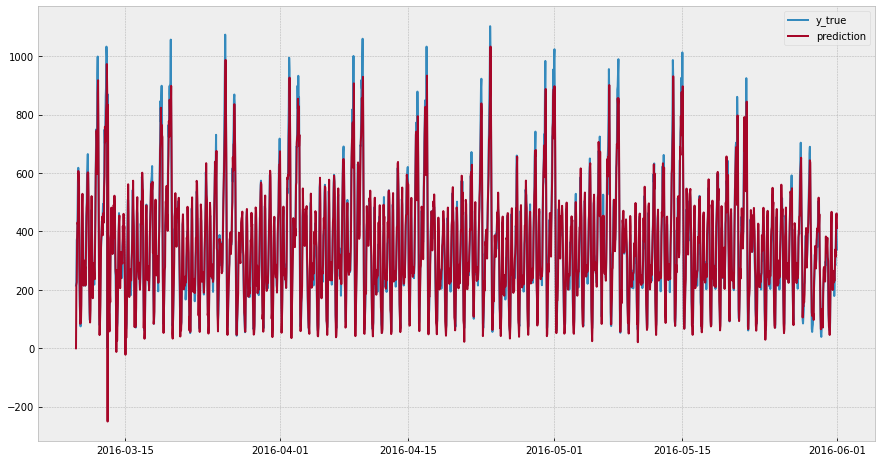

In [50]:
plt.plot(data_region['val'][-2000:], label='y_true')
plt.plot(model_sarimax.fittedvalues, label='prediction')

plt.legend()
plt.show()

In [74]:
data_short = data_region[-2000:]

6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Рассмотрим ещё раз остатки, построенной ранее линейной регрессии, видно, что присутствуют аномалии, попробуем создать признак, детектирующий аномалии

<AxesSubplot:xlabel='date'>

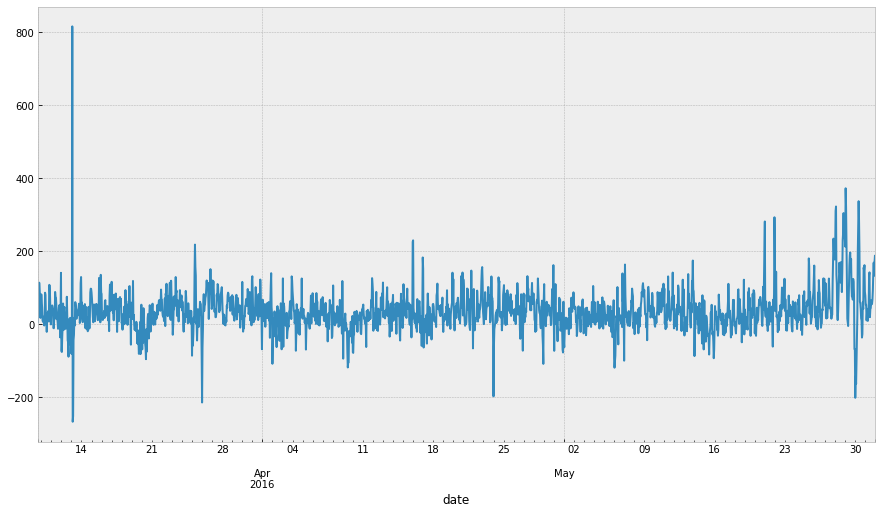

In [75]:
data_short['e'].plot()

In [76]:
data_short['outliers']= 0

In [77]:
data_short.loc[abs(data_short['val'])>200, 'outliers'] = 1

In [78]:
model_sarimax = SARIMAX(data_short['val'], 
                expg = data_short.drop(columns=['e', 'val']),
                order=(3, 1, 5), 
                seasonal_order=(1, 0, 1, 24)).fit(disp=-1)

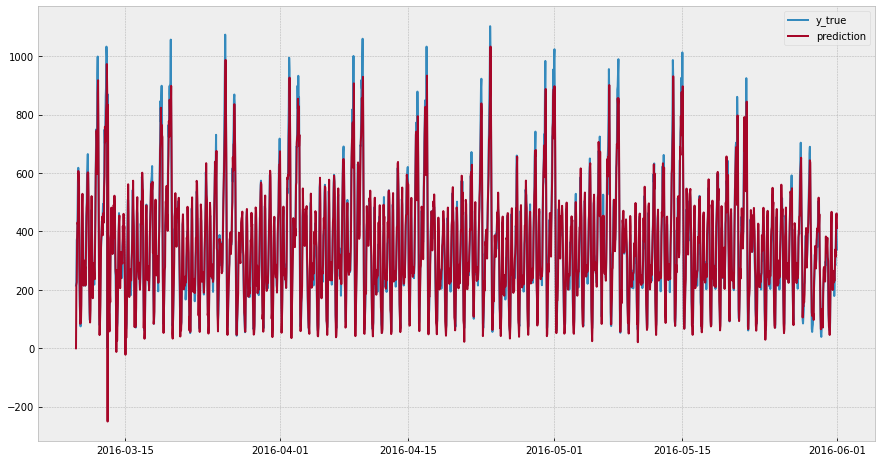

In [79]:
plt.plot(data_region['val'][-2000:], label='y_true')
plt.plot(model_sarimax.fittedvalues, label='prediction')
plt.legend()
plt.show()